# Structure Function science showcase

In [1]:
import tape
from tape import Ensemble
from tape.utils import ColumnMapper
from tape.analysis.structure_function.base_argument_container import StructureFunctionArgumentContainer
import eztao

import numpy as np
import matplotlib.pyplot as plt


# How to use different structure function calculators

- EzTao 

Text(0, 0.5, 'magnitude [unit]')

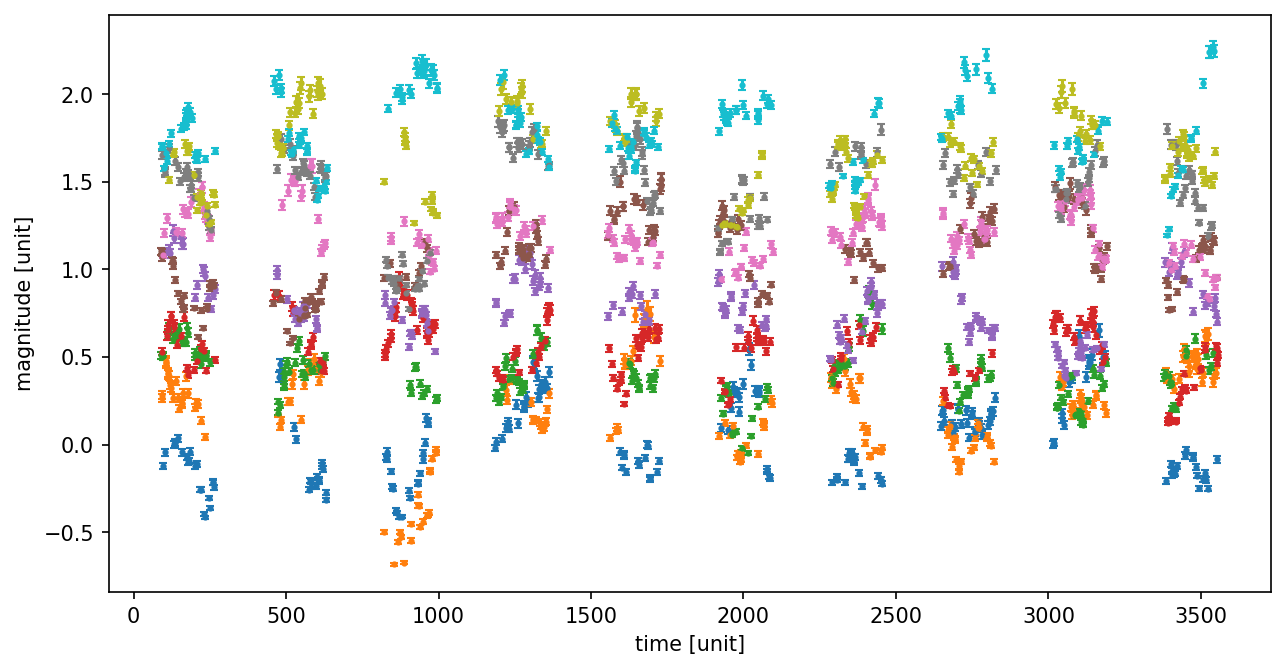

In [2]:
from eztao.carma import DRW_term
from eztao.ts import gpSimRand

# amp is RMS amplitude and tau is the decorrelation timescale
amp = 0.2
tau = 100

# Create the kernel
DRW_kernel = DRW_term(np.log(amp), np.log(tau))

num_light_curves = 100
snr = 10
duration_in_days = 365 * 10
num_observations = 200

# Generate `num_light_curves` lightcurves
# t, y, yerr are np.ndarray with shape = (num_light_curves, num_observations)
t, y, err = gpSimRand(
    carmaTerm=DRW_kernel,
    SNR=snr,
    duration=duration_in_days,
    N=num_observations,
    nLC=num_light_curves)

# pick 10 lightcurves at random and plot
plt.figure(dpi=150, figsize=(10,5))
for i, j in enumerate(np.random.choice(len(t), size=10, replace=False)):
    plt.errorbar(t[j], y[j]+i*0.2, yerr=err[j], ls='', marker='.', ms=4, capsize=2)
plt.xlabel('time [unit]')
plt.ylabel('magnitude [unit]')

# fig, ax = plt.subplots(10, 1, dpi=150, figsize=(8,3))
#for i, j in enumerate(np.random.choice(len(t), size=10, replace=False)):
#    ax[i].errorbar(t[j], y[j], err[j], fmt='.')

Run the example through the basic SF and plot
Mention linear bins
No errors

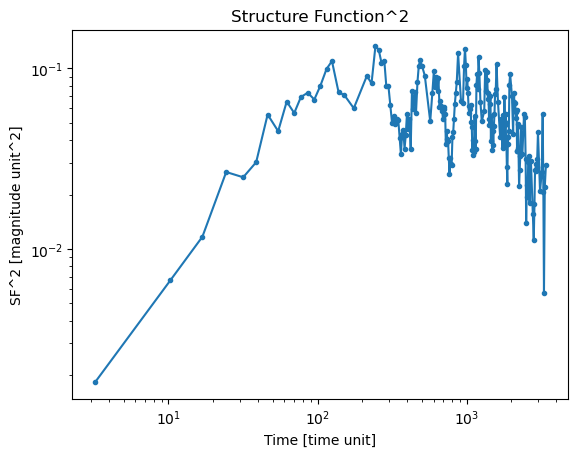

In [3]:
res_basic = tape.analysis.calc_sf2(t[0], y[0], err[0])

plt.figure()
plt.plot(res_basic['dt'], res_basic['sf2'], marker='.',)
plt.yscale('log')
plt.xscale('log')
plt.title("Structure Function^2")
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')
plt.show()

Put them all in ensamble and calculate

In [4]:
id_ens, t_ens, y_ens, yerr_ens, filter_ens\
    = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

for j in range(num_light_curves):
    id_ens = np.append(id_ens, np.full(num_observations, j))
    t_ens = np.append(t_ens, t[j])
    y_ens = np.append(y_ens, y[j])
    yerr_ens = np.append(yerr_ens, err[j])
    filter_ens = np.append(filter_ens, np.full(num_observations, 'r'))
    
""" 
data_dict = dict(
    lc_id = np.repeat(np.arange(1,101, dtype=int), repeats=200),
    band = np.hstack(np.full(np.shape(t), 'r')),
    time=np.hstack(t),
    flux=np.hstack(y),
    err=np.hstack(err)
)
"""       
id_ens = id_ens.astype(int)
# columns assigned manually
manual_colmap = ColumnMapper().assign(
    id_col="id_ens", time_col="t_ens", flux_col="y_ens",
    err_col="yerr_ens", band_col="filter_ens"
)

ens = Ensemble()
# ens.from_source_dict(source_dict=data_dict, column_mapper=manual_colmap)
ens.from_source_dict({'id_ens': id_ens, "t_ens": t_ens, 'y_ens': y_ens,
                      'yerr_ens': yerr_ens, 'filter_ens': filter_ens},
                        column_mapper=manual_colmap)

In [5]:
ens.head("object", 5)  


filter_ens,nobs_r,nobs_total
id_ens,,
0,200,200
1,200,200
2,200,200
3,200,200
4,200,200


In [10]:
arg_container = StructureFunctionArgumentContainer()
arg_container.combine = True
arg_container.bin_count_target = 1000
arg_container.calculation_repetitions = 20
arg_container.estimate_err = True
arg_container.report_upper_lower_error_separately = True
res_sf2 = ens.sf2(argument_container = arg_container)

In [11]:
# Theoretical SF
t_th = np.arange(0,10000,1)
SF_th = (amp**2 * 2) * (1-np.exp(-t_th/tau))

In [13]:
res_sf2

,lc_id,band,dt,sf2,1_sigma,lower_error,upper_error
0,combined,r,0.643266,-0.000349,0.0,0.0,0.0
1,combined,r,1.410553,0.000145,0.0,0.0,0.0
2,combined,r,2.137826,0.000895,0.0,0.0,0.0
3,combined,r,3.035129,0.001596,0.0,0.0,0.0
4,combined,r,4.005436,0.002079,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1985,combined,r,3448.302261,0.068051,0.0,0.0,0.0
1986,combined,r,3451.640238,0.057122,0.0,0.0,0.0
1987,combined,r,3455.107011,0.061782,0.0,0.0,0.0
1988,combined,r,3458.657693,0.049090,0.0,0.0,0.0


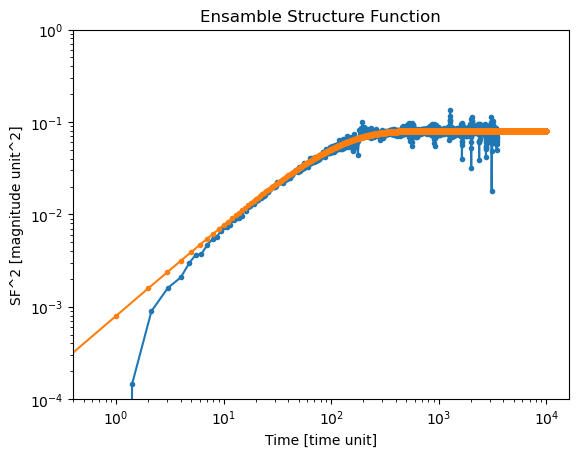

In [9]:
plt.figure()
plt.plot(res_sf2['dt'], res_sf2['sf2'], marker='.',)
plt.plot(t_th, SF_th, marker='.',)
plt.yscale('log')
plt.xscale('log')
plt.title("Ensamble Structure Function")
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')
plt.ylim(10**(-4), 1)
plt.show()

## Run the data through the other SF methods and plot those.

In [34]:
arg_container = tape.analysis.structure_function.StructureFunctionArgumentContainer()



arg_container.sf_method = 'macleod_2012'
arg_container.combine = True
arg_container.bin_count_target = 1000
arg_container.calculation_repetitions = 100
res_macleod = ens.sf2( argument_container=arg_container)


arg_container.sf_method = 'bauer_2009a'
res_bauer_a = ens.sf2(argument_container=arg_container)

arg_container.sf_method = 'bauer_2009b'
res_bauer_b = ens.sf2(argument_container=arg_container)

arg_container.sf_method = 'schmidt_2010'
res_schmidt = ens.sf2(argument_container=arg_container)


KeyboardInterrupt: 

Text(0, 0.5, 'SF^2 [magnitude unit^2]')

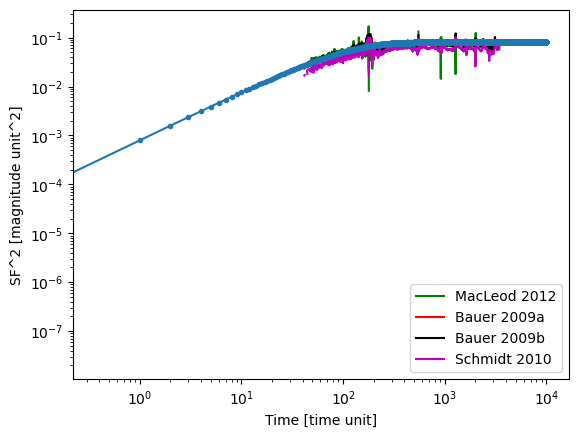

In [33]:
# plt.plot(res_basic['dt'], res_basic['sf2'], 'b', label='Basic', lw = 3, marker = 'o')
plt.plot(res_macleod['dt'], res_macleod['sf2'], 'g', label='MacLeod 2012')
plt.plot(res_bauer_a['dt'], res_bauer_a['sf2'], 'r', label='Bauer 2009a')
plt.plot(res_bauer_b['dt'], res_bauer_b['sf2'], 'k', label='Bauer 2009b')
plt.plot(res_schmidt['dt'], res_schmidt['sf2'], 'm', label='Schmidt 2010')
plt.plot(t_th, SF_th, marker='.',)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Time [time unit]')
plt.ylabel('SF^2 [magnitude unit^2]')